### 시간에 대해서 clustering을 시도한 흔적입니다

In [65]:
import click_stream
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans

In [104]:
def derive_inertia_series(fit_data, cluster_range = (2, 10)):
    """Elbow method를 위한 KMeans inertia line plot function"""
    inertia_list = list()
    
    for n_clusters in range(cluster_range[0], cluster_range[1]):
        candidate = KMeans(n_clusters = n_clusters)
        candidate.fit(fit_data)
        inertia_list.append(candidate.inertia_)
        
    plt.plot(range(cluster_range[0], cluster_range[1]), inertia_list)
    plt.show()
    
def derive_cluster(fit_data: pd.DataFrame, n_cluster):
    """데이터를 클러스터링 한 후에 그래프를 그립니다."""
    original_columns = fit_data.columns
    
    kmeans = KMeans(n_clusters = n_cluster)
    kmeans.fit(fit_data)
    
    fit_data = fit_data.copy()
    fit_data['ClusterLabel'] = kmeans.labels_
    cluster_gp = fit_data.groupby('ClusterLabel')
    
    cluster_description = pd.DataFrame(
        data = [cluster_gp[column].mean() for column in original_columns]
    )

    px.line(data_frame = cluster_description, x = cluster_description.index, y = [0, 1, 2, 3]).show()
    
    fit_data = fit_data.join(pd.read_excel('./train_profiles.xlsx')
                               .set_index('CUS_ID'), 
                             how = 'inner')
    
    cross_tab = fit_data.groupby(['ClusterLabel', 'GROUP'])[[0]]\
                        .count()\
                        .reset_index()\
                        .pivot(columns = 'ClusterLabel', index = 'GROUP', values = 0)
    cross_tab_summation = cross_tab.sum(axis = 1)

    for col in cross_tab.columns:
        cross_tab[col] /= cross_tab_summation
    
    return round(cross_tab * 100, 2)

In [85]:
data = click_stream.read_click_stream(file_name = 'train_clickstreams.tab')
data = click_stream.preprocess_time_column(data)

In [94]:
cluster_data = pd.pivot_table(
    data = data, 
    index = 'CUS_ID', 
    columns = ['WEEKDAY_TIME'], 
    values = ['ST_TIME'], 
    aggfunc = 'sum'
)['ST_TIME'].fillna(0)

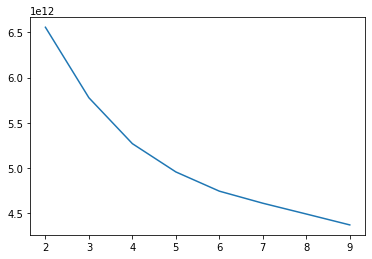

In [87]:
derive_inertia_series(cluster_data)

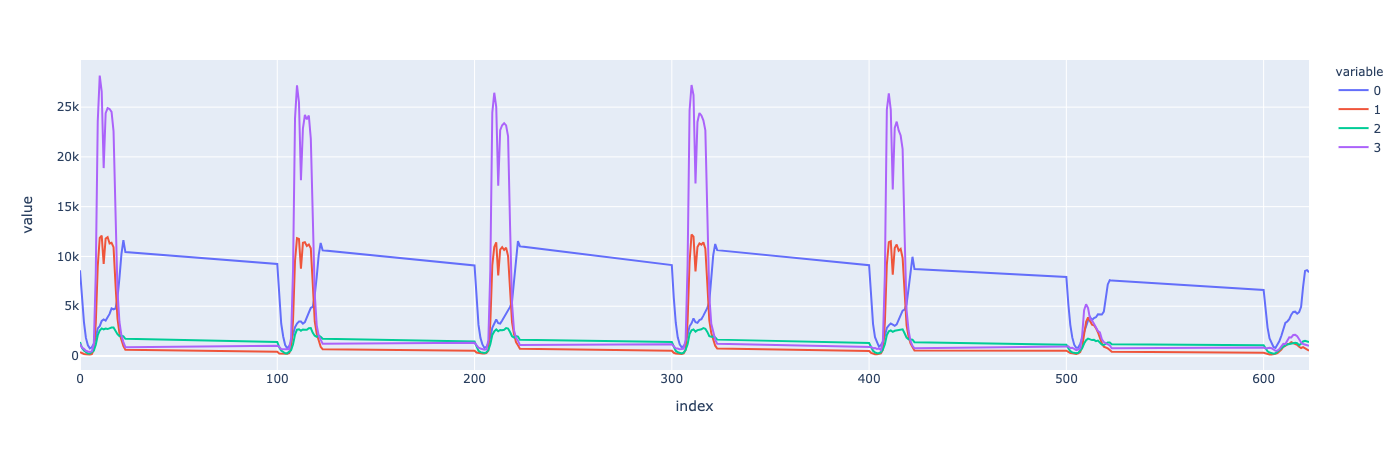

ClusterLabel,0,1,2,3
GROUP,,,,
F20-,10.37,29.46,52.70,7.47
F30,11.46,27.51,53.30,7.74
F40+,5.25,21.91,67.59,5.25
M20-,7.73,20.60,69.10,2.58
M30,10.66,21.48,61.15,6.72
M40+,13.32,21.40,60.43,4.85


In [105]:
derive_cluster(cluster_data, 4)

### 클러스터를 했을 때 그렇게 유의한 결과를 보여주지는 않음